In [677]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.ndimage import median_filter

In [678]:
# Functions to compute alpha and beta
def get_alpha(u, P):
    if u == 1:
        return np.sqrt(1/P)
    else:
        return np.sqrt(2/P)

def get_beta(v, Q):
    if v == 1:
        return np.sqrt(1/Q)
    else:
        return np.sqrt(2/Q)

In [679]:
# Function to get the basis chip
def get_basis_chip(u, v, P=8, Q=8):
    
    # Compute alpha and beta
    a_u = get_alpha(u, P)
    b_v = get_beta(v, Q)
    
    # Create empty basis chip
    basis_chip = np.zeros((P, Q))
    
    # Calculate the basis chip
    for x in range(1, P+1):
        for y in range(1, Q+1):
            basis_chip[y-1, x-1] = a_u * b_v * np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P)) * np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))
    
    # Return the basis chip with the right orientation
    return basis_chip

In [680]:
# Function to calculate convert basis chip into basis vector
def get_basis_vector_matrix(K=8):
    num_basis_vectors = K**2
    
    # Initialize the 64x64 basis vector matrix
    basis_vector_matrix = np.zeros((num_basis_vectors, num_basis_vectors))
    
    # Get all basis chips and rasterize them into column vectors
    index = 0
    for u in range(1, K + 1):
        for v in range(1, K + 1):
            # Get the basis chip
            basis_chip = get_basis_chip(u, v, P=K, Q=K)
            
            # Rasterize the basis chip into a column vector
            basis_vector_matrix[:, index] = basis_chip.flatten(order='F')
            index += 1

    return basis_vector_matrix

In [681]:
# Generate the 8x8 corrupted image block (chip)
def generate_corrupted(S=30, block_size=8, block=None):
    # Generate the mask
    total_pixels = block_size * block_size
    indices = np.random.choice(total_pixels, S, replace=False)
    
    # Normalize the grayscale block to the range 0–255
    block_normalized = (block - block.min()) / (block.max() - block.min()) * 255
    block_normalized = block_normalized.astype(np.uint8)

    # Generate a mask and set missing pixel intensities to NaN
    mask = np.zeros((block_size, block_size), dtype=bool)
    for index in indices:
        row, col = divmod(index, block_size)
        mask[row, col] = True
    
    # Sets corrupted pixels to NaN
    nan_block = block.astype(float)
    nan_block[~mask] = np.nan
    
    return nan_block, mask
    

In [683]:
def apply_lasso_reconstruction(B, block, mask, alpha):
    # Flatten block and mask
    C = block.flatten(order='F')
    sampling_mask = mask.flatten(order='F')

    # Create A and D matrices
    D = C[sampling_mask]
    A = B[sampling_mask, :]

    # Apply LASSO regression
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(A, D)
    kappa_est = lasso.coef_
    intercept = lasso.intercept_

    # Reconstruct image chip
    C_hat = B @ kappa_est + intercept
    C_hat = C_hat.reshape(8, 8, order='F')

    return C_hat, kappa_est


In [684]:
def cross_validation_random(S, corrupted_block, B):
        # Parameters for Cross-validation
        num_testing = S // 6 # Number of pixels in test set
        lambda_values = np.logspace(-7, 2, 11) # Values of lambda to test

        # Initialize subplots
        fig, axes = plt.subplots(3, len(lambda_values), figsize=(30, 10))
    
        # Initialize list to store MSE values
        mse_values = []
    
        # From sensed pixels, randomly select test and train pixels
        sensed_pixels = np.argwhere(~np.isnan(corrupted_block))
        np.random.shuffle(sensed_pixels)

        # Split into test and train pixels
        test_pixels = sensed_pixels[:num_testing]
        train_pixels = sensed_pixels[num_testing:]

        # Create mask for training pixels
        train_mask = np.zeros_like(corrupted_block, dtype=bool)
        train_mask[tuple(train_pixels.T)] = True

        train_block = corrupted_block.copy()
        train_block[~train_mask] = np.nan
    
        for i, alpha in enumerate(lambda_values):
                # Apply LASSO reconstruction
                reconstructed_block, kappa_est = apply_lasso_reconstruction(B, train_block, train_mask, alpha)
                reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
                
                # Display original corrupted and reconstructed images
                axes[0, i].imshow(corrupted_block, cmap='gray')
                axes[0, i].set_title(f"Corrupted\nλ={alpha:.1e}")
                axes[0, i].axis("off")
                
                axes[1, i].imshow(reconstructed_block, cmap='gray')
                axes[1, i].set_title(f"Reconstructed\nλ={alpha:.1e}")
                axes[1, i].axis("off")
                
                # Stem plot for model weights (kappa_est)
                axes[2, i].stem(kappa_est)
                axes[2, i].set_title(f"Model Weights\nλ={alpha:.1e}")
                axes[2, i].set_xlabel("Coefficient Index")
                axes[2, i].set_ylabel("Weight Value")
                
                # Extract reconstructed values at the test pixel locations
                test_values_reconstructed = reconstructed_block[tuple(test_pixels.T)]
                test_values_original = corrupted_block[tuple(test_pixels.T)]
                
                valid_indices = ~np.isnan(test_values_original) & ~np.isnan(test_values_reconstructed)
                test_values_original = test_values_original[valid_indices]
                test_values_reconstructed = test_values_reconstructed[valid_indices]
                
                # Calculate MSE
                # Compute MSE only if there are valid values
                if len(test_values_original) > 0 and len(test_values_reconstructed) > 0:
                        mse = mean_squared_error(test_values_original, test_values_reconstructed)
                        mse_values.append(mse)
                else:
                        mse_values.append(np.nan)  # Append NaN if no valid values


        plt.suptitle("Comparison of Corrupted vs Reconstructed Image & Model Weights for Different Lambdas")
        plt.tight_layout()
        plt.show()
        
        # Plot MSE vs lambda
        plt.figure(figsize=(8, 6))
        plt.plot(lambda_values, mse_values, marker='o', linestyle='-')
        plt.xscale('log')  # Log scale for lambda
        plt.xlabel(r'Regularization Parameter $\lambda$')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title('MSE vs. Lambda')
        plt.grid(True)
        plt.show()


In [685]:
def cross_validation_multiple(S, num_subsets, corrupted_block, B):
    # Parameters for Cross-validation
    num_testing = S // 6 # Number of pixels in test set
    lambda_values = np.logspace(-7, 2, 11) # Values of lambda to test
    
    # Initialize list to store MSE values
    mse_curves = []
    
    for subset in range(num_subsets):
        # From sensed pixels, randomly select test and train pixels
        sensed_pixels = np.argwhere(~np.isnan(corrupted_block))
        np.random.shuffle(sensed_pixels)

        # Split into test and train pixels
        test_pixels = sensed_pixels[:num_testing]
        train_pixels = sensed_pixels[num_testing:]

        # Create mask for training pixels
        train_mask = np.zeros_like(corrupted_block, dtype=bool)
        train_mask[tuple(train_pixels.T)] = True

        train_block = corrupted_block.copy()
        train_block[~train_mask] = np.nan
        
        # Array to store MSE values for each subset
        mse_values = []
        
        # Iterate over all lambda values
        for alpha in lambda_values:
            # Apply LASSO reconstruction
            reconstructed_block, kappa_est = apply_lasso_reconstruction(B, train_block, train_mask, alpha)
            reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
            
            # Compute MSE for test pixels
            test_values_reconstructed = reconstructed_block[tuple(test_pixels.T)]
            test_values_original = corrupted_block[tuple(test_pixels.T)]
            
            valid_indices = ~np.isnan(test_values_original) & ~np.isnan(test_values_reconstructed)
            test_values_original = test_values_original[valid_indices]
            test_values_reconstructed = test_values_reconstructed[valid_indices]
            
            # Calculate MSE
            # Compute MSE only if there are valid values
            if len(test_values_original) > 0 and len(test_values_reconstructed) > 0:
                    mse = mean_squared_error(test_values_original, test_values_reconstructed)
                    mse_values.append(mse)
            else:
                    mse_values.append(np.nan)  # Append NaN if no valid values
        
        # Append the MSE values for the current subset
        mse_curves.append(mse_values)
        avg_mse = np.mean(mse_curves, axis=0)
    
    
    mse_curves = np.array(mse_curves)
    avg_mse = np.mean(mse_curves, axis=0)
    
    # Plot the MSE vs lambda values for each subset
    plt.figure(figsize=(10, 6))
    for curve in mse_curves:
        plt.plot(lambda_values, curve, color='gray', alpha=0.5, linestyle='--')  # Thin gray lines for individual curves
    
    plt.plot(lambda_values, avg_mse, color='red', linewidth=2, marker='o', label='Average MSE')  # Thicker red line for average
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs. Lambda')
    plt.legend()
    plt.show()

In [686]:
def display_model_weight(kappa_est):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.stem(range(len(kappa_est)), kappa_est, use_line_collection=True)
    ax.set_xlabel("Basis Vector Index")
    ax.set_ylabel("Weight Magnitude")
    ax.set_title("Model Weights for Selected λ")
    plt.show()

In [689]:
def generate_corrupted_image(image_array, S, block_size=8):
    height, width = image_array.shape
    corrupted_image = image_array.astype(float).copy()

    # Process each block independently
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image_array[i:i+block_size, j:j+block_size]
            
            # Check if block is full size (edge cases for non-multiple sizes)
            if block.shape[0] == block_size and block.shape[1] == block_size:
                corrupted_block, _ = generate_corrupted(S, block_size, block)
                corrupted_image[i:i+block_size, j:j+block_size] = corrupted_block

    return corrupted_image

In [690]:
def image_reconstruction(image_array, corrupted_image, block_size=8, alpha=None, B=None):
    # Initialize the reconstructed image
    height, width = image_array.shape
    reconstructed_image = np.zeros_like(image_array, dtype=float)
    
    # Reconstruct each block in the image
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = corrupted_image[i:i+block_size, j:j+block_size]
            mask = ~np.isnan(block)
            
            if np.sum(mask) > 0:  # Ensure there are valid pixels
                reconstructed_block, _ = apply_lasso_reconstruction(B, block, mask, alpha)
                reconstructed_image[i:i+block_size, j:j+block_size] = reconstructed_block
                
    # Apply median filtering to the reconstructed image
    reconstructed_image_filtered = median_filter(reconstructed_image, size=3)
    
    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(corrupted_image, cmap='gray')
    axes[0].set_title("Corrupted Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Image (No Filtering)")
    axes[1].axis("off")

    axes[2].imshow(reconstructed_image_filtered, cmap='gray')
    axes[2].set_title("Reconstructed Image (With Median Filtering)")
    axes[2].axis("off")

    axes[3].imshow(image_array, cmap='gray')
    axes[3].set_title("Original Image")
    axes[3].axis("off")

    plt.show()

In [691]:
# Load image
image_path = '../data/fishing_boat.bmp'
image = Image.open(image_path).convert('L')

# Convert the image to a numpy array
image_array = np.array(image)

In [692]:
# Display the 8x8 block with the top-left pixel at (x, y) = (x*, y*)
x_star = 8 * (4-1) + 1
y_star = 8 * (2-1) + 1

# Get the 8x8 block
block_size = 8
x_start = x_star - 1
y_start = y_star - 1

# Get the block end coordinates
x_end = min(x_start + block_size, image_array.shape[0])
y_end = min(y_start + block_size, image_array.shape[1])

# Gets the 8x8 block
block = image_array[x_start:x_end, y_start:y_end]

In [693]:
# Generate the 8x8 corrupted image block (chip)
S = 30
corrupted_block, mask = generate_corrupted(S, block_size=8, block=block)

In [694]:
# Get the vector matrix
B = get_basis_vector_matrix(K=8)

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.476e-01, tolerance: 4.898e-01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e-01, tolerance: 4.898e-01
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_410562/374050102.py:30: RuntimeWarning: invalid value encountered in divide
  reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
/tmp/ipykernel_410562/3740501

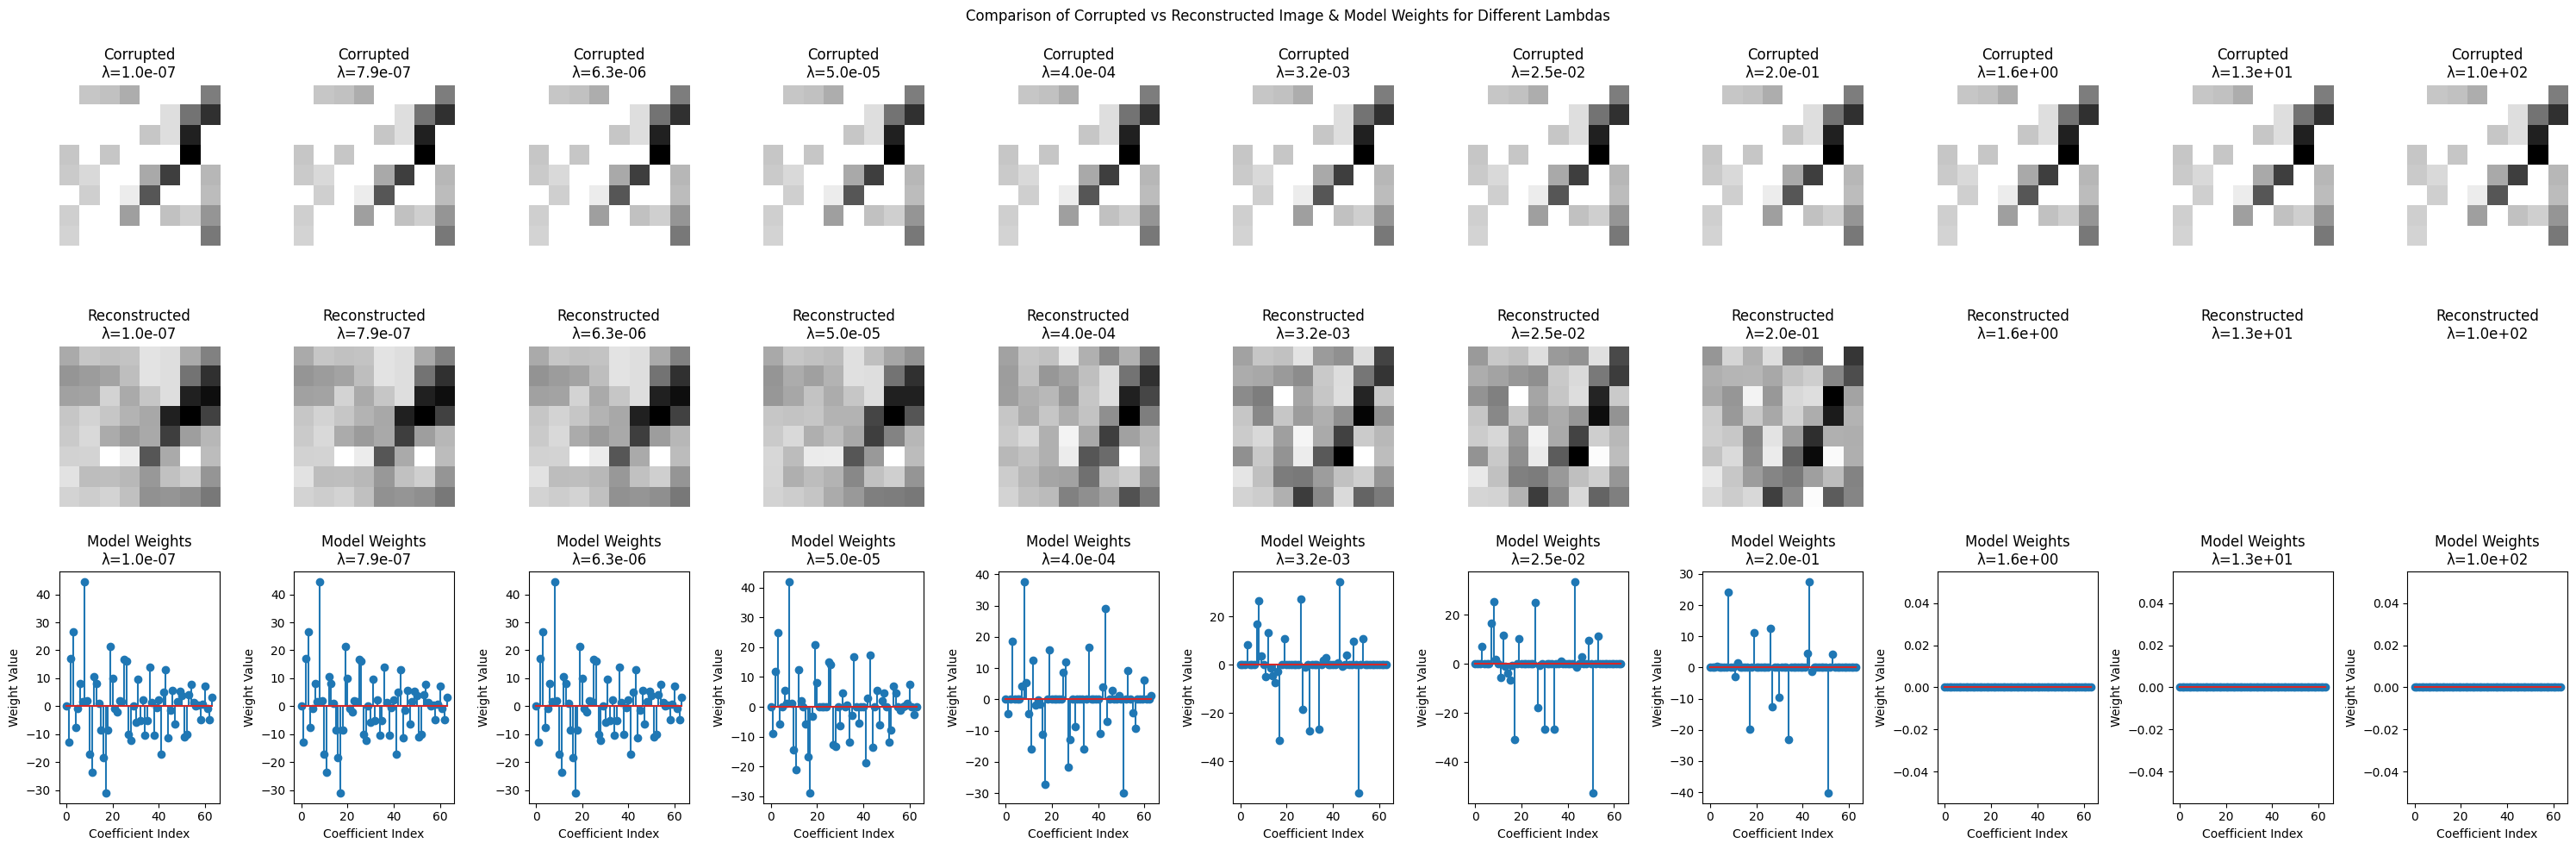

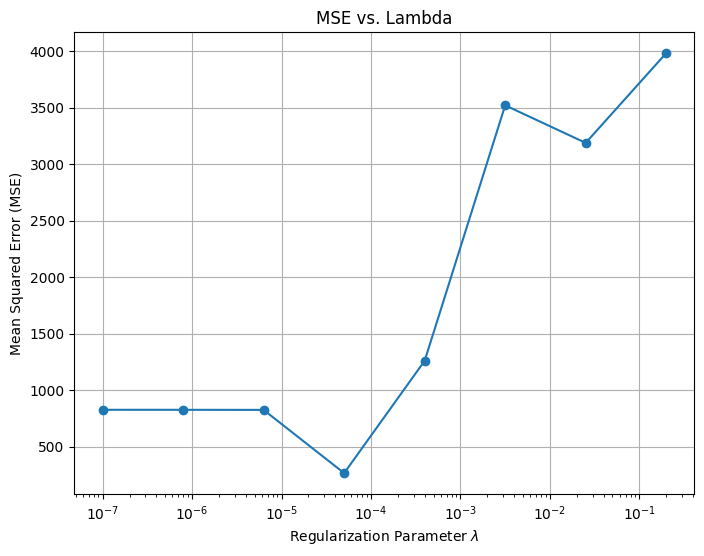

In [695]:
# Chip reconstruction
cross_validation_random(S, corrupted_block, B)

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.957e-01, tolerance: 4.132e-01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+00, tolerance: 4.132e-01
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_410562/2153625706.py:32: RuntimeWarning: invalid value encountered in divide
  reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
/tmp/ipykernel_410562/215362

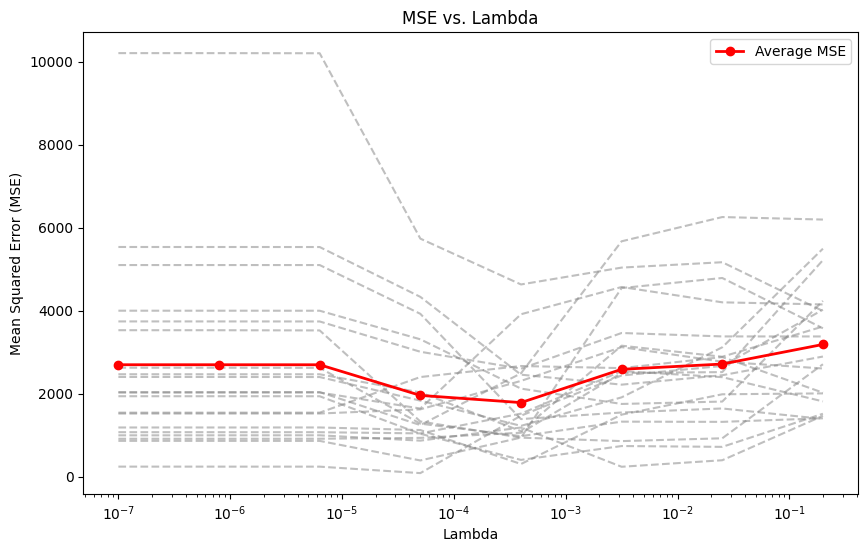

In [696]:
# Cross validation for 20 subsets
num_subsets = 20
cross_validation_multiple(S, num_subsets, corrupted_block, B)

In [697]:
alpha = 3e-3
reconstructed_block, kappa_est = apply_lasso_reconstruction(B, corrupted_block, mask, alpha)

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+00, tolerance: 5.123e-01
  model = cd_fast.enet_coordinate_descent(


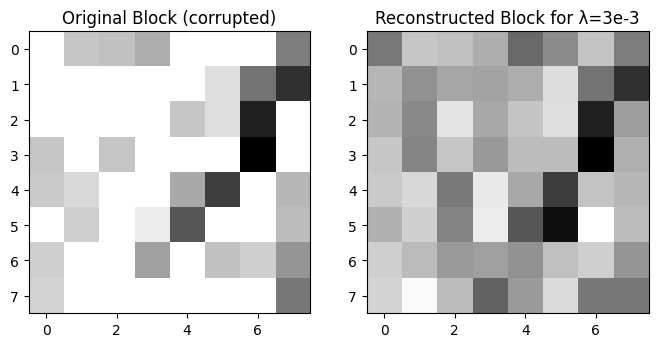

In [698]:
# Display Original vs Reconstructed
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(corrupted_block, cmap='gray')
ax[0].set_title("Original Block (corrupted)")
ax[1].imshow(reconstructed_block, cmap='gray')
ax[1].set_title("Reconstructed Block for λ=3e-3")
plt.show()

In [699]:
# Generate corrupted image
corrupted_image = generate_corrupted_image(image_array, S)

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+00, tolerance: 1.334e+00
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 7.234e-02
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

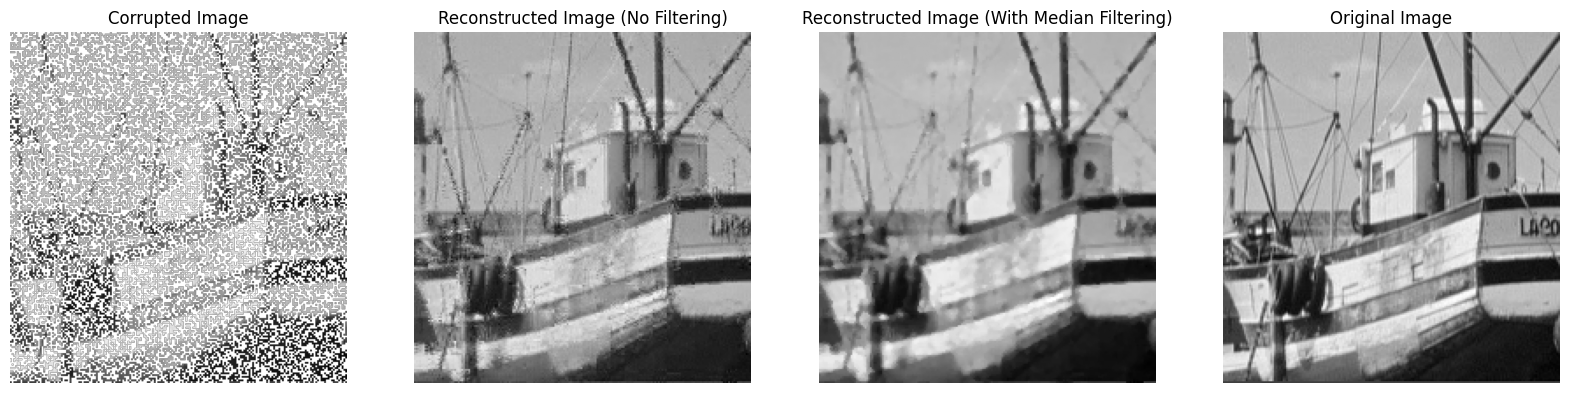

In [700]:
# Reconstruct image
image_reconstruction(image_array, corrupted_image, alpha=alpha, B=B)